<a href="https://colab.research.google.com/github/minhtriet2507/DoAnHMTK_DS102.L21/blob/main/SourceCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FAKE NEWS DETECTION PROBLEM

## * Cài đặt và khai báo thư viện

In [1]:
pip install wordcloud

In [2]:
pip install gensim

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Tien xu ly du lieu
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction import text
import re, string
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

#Trich xuất đặc trưng
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec, KeyedVectors

#Các mô hình học máy
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

#Các độ đo đánh giá
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, plot_confusion_matrix,auc,roc_curve

#Tinh chỉnh
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## 1. Load Dataset

In [4]:
path = '/content/drive/MyDrive/#2020-2021 HK2/HMTK/DoAnCuoiKy/Source code DoAn/news.csv'
#path = 'https://s3.amazonaws.com/assets.datacamp.com/blog_assets/fake_or_real_news.csv'
data = pd.read_csv(path)

## 2. Khám phá dữ liệu :&gt;

**Thông tin chung**

In [5]:
data.head(5)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [7]:
print(data['title'][0])

You Can Smell Hillary’s Fear


In [8]:
print(data['label'][0])

FAKE


**Phân bố nhãn**

REAL    3171
FAKE    3164
Name: label, dtype: int64


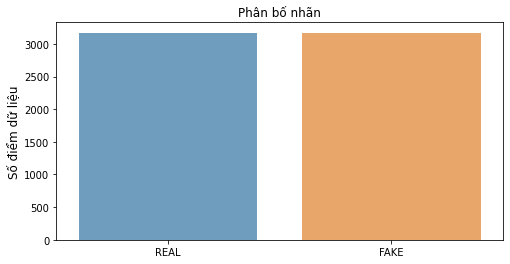

In [9]:
label = data['label'].value_counts()
print(label)
plt.figure(figsize=(8,4))
sns.barplot(x=label.index, y=label.values, alpha=0.7)
plt.title("Phân bố nhãn")
plt.ylabel('Số điểm dữ liệu', fontsize=12)
plt.show()

**Độ dài nội dung**

Mô tả độ dài của nội dung: 
                text
count    6335.000000
mean     4707.250355
std      5090.956446
min         1.000000
25%      1741.500000
50%      3642.000000
75%      6192.000000
max    115372.000000


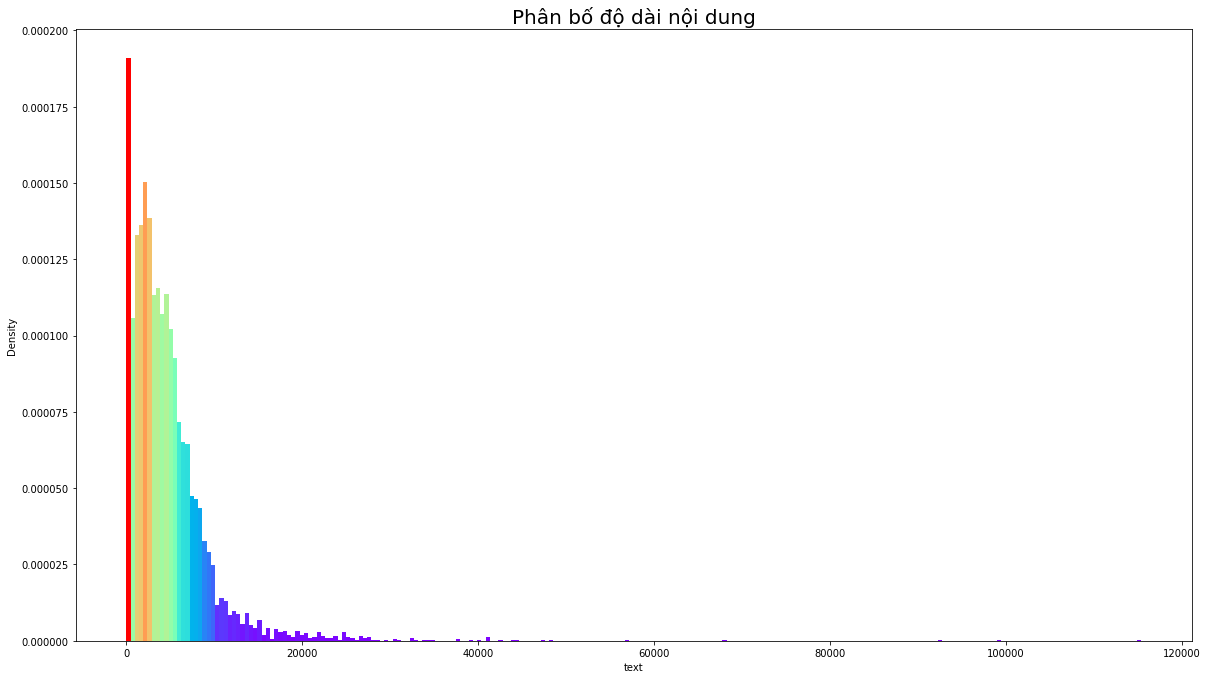

In [10]:
print('Mô tả độ dài của nội dung: ')
length = data['text'].apply(len)
table = pd.DataFrame(length.describe())
print(table)

plt.figure(figsize = (20,11.25))
ax = sns.histplot(length, kde=False, stat="density", linewidth=0)
values = np.array([patch.get_height() for patch in ax.patches])

norm = plt.Normalize(values.min(), values.max())
colors = plt.cm.rainbow(norm(values))

for patch, color in zip(ax.patches, colors):
    patch.set_color(color)

plt.title('Phân bố độ dài nội dung', size = 20, color = 'black')
plt.show()

**Những từ xuất hiện nhiều ở mỗi nhãn**

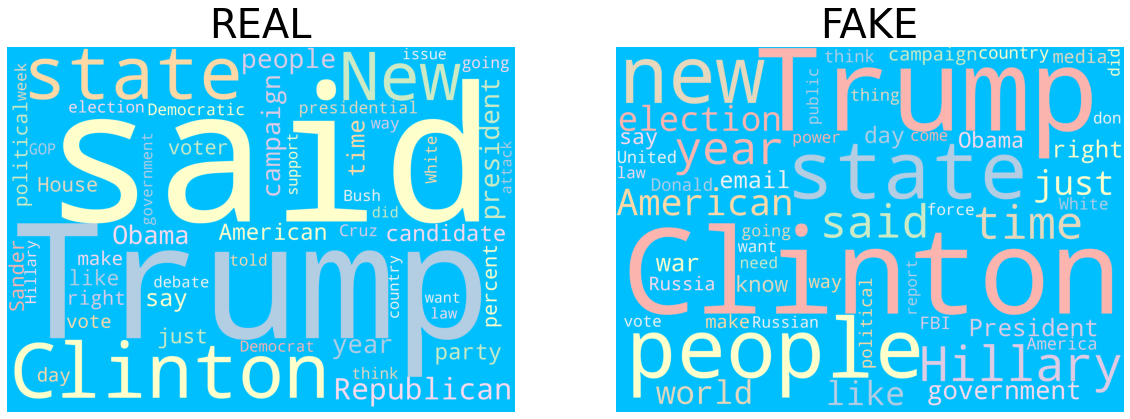

In [11]:
plt.figure(figsize=(20,20))
labels =['REAL','FAKE']

for indx,val in enumerate(labels):
    ax=plt.subplot(1,2,indx+1)
    subset = data[data['label']==val]
    text1 = subset['text'].values
    cloud = WordCloud(
                        stopwords=text.ENGLISH_STOP_WORDS,
                        background_color='deepskyblue',
                        collocations=False,
                        width=2500,
                        height=1800,
                        colormap = "Pastel1",
                        random_state = 42,
                        max_words= 50
                        ).generate(" ".join(text1))
    plt.axis('off')
    plt.title(val,fontsize=40)
    plt.imshow(cloud)

In [190]:
def tokenize(s):
  return re.sub(f'[{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’]','',s).split()

def visualize_word_freq(input_data,max_words,title_pre,ax1,ngram,tfidf=False):
    if tfidf:
        vectorizer = TfidfVectorizer(max_features=max_words,stop_words=set(text.ENGLISH_STOP_WORDS),ngram_range=ngram,use_idf=True,
                                     tokenizer=tokenize,token_pattern = None, analyzer='word',
                                     min_df=5, max_df=0.9, strip_accents='unicode',
                                     smooth_idf=1, sublinear_tf=1)
        TITLE = title_pre+" - "+"Most Freq Words (TFIDF)"
    else:
        vectorizer = CountVectorizer(max_features=max_words,stop_words='english')
        TITLE = title_pre+" - "+"Most Freq Words"
    mat = vectorizer.fit_transform(input_data)
    df = pd.DataFrame(mat.sum(axis=0).T,index=vectorizer.get_feature_names(),columns=['freq']).sort_values(by='freq',
                                                                                                           ascending=False)
    ax = sns.barplot(x='freq',y=df.index,data=df,ax=ax1,palette='mako')
    ax.set_title(TITLE)

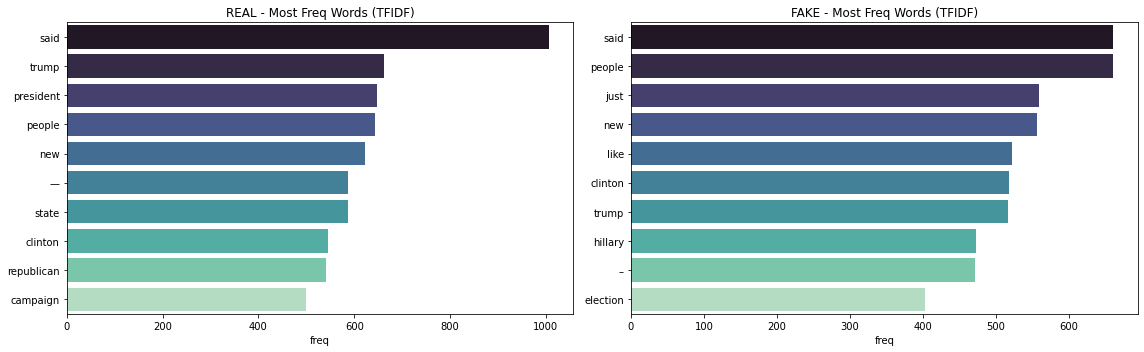

In [192]:
labels =['REAL','FAKE']
fig, ax = plt.subplots(1,2, figsize=(16,5))
for indx,val in enumerate(labels):
    subset = data[data['label']==val]
    text1 = subset['text'].values
    visualize_word_freq(text1,10, val,ax[indx],(1,1),tfidf=True)
    plt.tight_layout()

## 3. Tiền xử lý và vector hóa dữ liệu

###       3.1. Tiền xử lý dữ liệu

**Chia train - test**

In [161]:
X = data[['title', 'text']]
y = data['label']

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=42)
train,test = train_test_split(data,train_size=0.75,random_state=42)

**Gộp 2 cột title và text**

In [162]:
X_train = X_train[['title', 'text']].agg(' '.join, axis=1)# Merge cột title và text
X_test = X_test[['title', 'text']].agg(' '.join, axis=1)# Merge cột title và text

y_train = y_train.apply(lambda x: 1 if x=='FAKE' else 0)# REAL:0 -FAKE:1
y_test = y_test.apply(lambda x: 1 if x=='FAKE' else 0)

**Tiền xử lý dữ liệu**

In [163]:
stopwords = set(text.ENGLISH_STOP_WORDS)

def tokenize(s):
  return re.sub(f'[{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’]','',s).split() # tách câu thành list of các từ và bỏ đi ký tự đặc biệt

def preprocessing(X):
  X_p = []
  for text in X:
    text = ''.join(i for i in text if not i.isdigit()) #Bỏ số
    token_list = tokenize(text)# tách từ
    text_modified = ''

    for token in token_list:
      if not token in stopwords:# bỏ đi những từ trong danh sách stopwords
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token,'a')# chuyển từ về dạng nguyên mẫu
        text_modified += token + ' '
    X_p.append(text_modified)
  return X_p

In [164]:
X_train = preprocessing(X_train)
X_test = preprocessing(X_test)

###       3.3. Vector hóa dùng mô hình Bag-of-Words

###           3.3.1. Vector hóa dữ liệu dùng CountVectorizer

In [18]:
count_vectiorizer = CountVectorizer(ngram_range=(1,2),tokenizer=tokenize,token_pattern = None,analyzer='word',
                                  min_df=5, max_df=0.9, strip_accents='unicode')

X_train_cv = count_vectiorizer.fit_transform(X_train)
X_test_cv = count_vectiorizer.transform(X_test)

###           3.3.2. Vector hóa dữ liệu dùng TfidfVectorizer

In [19]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),tokenizer=tokenize,token_pattern = None, analyzer='word',
                                  min_df=5, max_df=0.9, strip_accents='unicode', use_idf=1,
                                  smooth_idf=1, sublinear_tf=1)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

###       3.4. Vector hóa dữ liệu dùng pretrain model Word2Vec

In [20]:
%time w2v_model = gensim_api.load("word2vec-google-news-300") #9min44s
# %time w2v_model = KeyedVectors.load_word2vec_format('/datasets/drive/Colab Notebooks/GoogleNews-vectors-negative300.bin', binary=True)
print('done loading Word2Vec')

def embedding_feats(list_of_lists):
    DIMENSION = 300
    zero_vector = np.zeros(DIMENSION)
    feats = []
    for tokens in list_of_lists:
        tokens = tokenize(tokens)
        feat_for_this =  np.zeros(DIMENSION)
        count_for_this = 0 + 1e-5 # to avoid divide-by-zero 
        for token in tokens:
            if token in w2v_model:
                feat_for_this += w2v_model[token]
                count_for_this +=1
        feats.append(feat_for_this/count_for_this)   
    return feats

[==================================================] 100.0% 1662.8/1662.8MB downloaded
CPU times: user 8min 45s, sys: 58.9 s, total: 9min 44s
Wall time: 11min 57s
done loading Word2Vec


In [21]:
X_train_w2v = embedding_feats(X_train)
X_test_w2v = embedding_feats(X_test)

In [22]:
scaler = MinMaxScaler()
X_train_w2v = scaler.fit_transform(X_train_w2v)
X_test_w2v = scaler.transform(X_test_w2v)

## 4. Huấn luyện mô hình và dự đoán kết quả

**Hàm đánh giá kết quả mô hình**

In [23]:
def train_and_get_metric_scores(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    #print(confusion_matrix(y_test,y_pred))

    #confusion matrix
    disp = plot_confusion_matrix(model, X_test, y_test,
                                cmap=plt.cm.Blues,
                                normalize=None,values_format = '.0f')
    plt.show()

    #metrics
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred, average='macro')

    metrics = {"accuracy": round(accuracy,4),
               "precision": round(precision,4),
               "recall": round(recall,4),
               "f1": round(f1,4)}

    return y_pred,metrics

###       4.1. Logistic Regression

CountVectorizer
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       790
           1       0.93      0.94      0.94       794

    accuracy                           0.94      1584
   macro avg       0.94      0.94      0.94      1584
weighted avg       0.94      0.94      0.94      1584



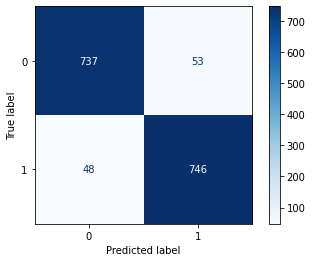

TfidfVectorizer
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       790
           1       0.96      0.96      0.96       794

    accuracy                           0.96      1584
   macro avg       0.96      0.96      0.96      1584
weighted avg       0.96      0.96      0.96      1584



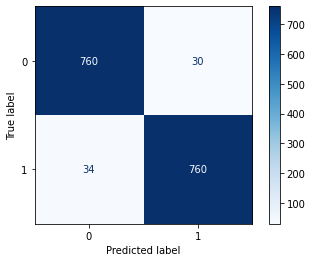

Word2Vec
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       790
           1       0.93      0.90      0.91       794

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584



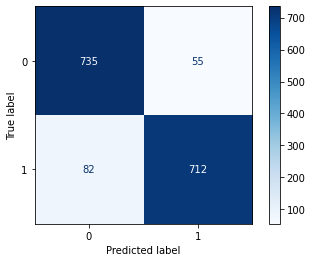

In [24]:
lr = {'CountVectorizer':[X_train_cv, X_test_cv,{'C':1,'solver': 'sag'}],
      'TfidfVectorizer':[X_train_tfidf,X_test_tfidf,{'C': 1000, 'solver': 'saga'}],
      'Word2Vec':[X_train_w2v,X_test_w2v,{'C': 10, 'solver': 'newton-cg'}]}

param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                 'solver':['newton-cg', 'lbfgs', 'sag', 'saga']}
                 
for vectorizer,val in lr.items():
    print(vectorizer)

    #gridsearchCV
    # clf_lr = LogisticRegression(max_iter=len(X_train),random_state=42)
    # grid_search_lr = GridSearchCV(clf_lr,param_grid_lr,cv=3,scoring='f1_macro',n_jobs=4)
    # grid_search_lr.fit(val[0],y_train)
    # print(grid_search_lr.best_params_)
    # clf_lr = grid_search_lr.best_estimator_

    # best_estimators
    clf_lr = LogisticRegression(max_iter=len(X_train),random_state=42,**val[2])
    y_pred, metric_scores = train_and_get_metric_scores(clf_lr,val[0],val[1],y_train,y_test)
    val.append(y_pred)
    val.append(metric_scores)

###       4.2. Multinomial Naive Bayes

CountVectorizer
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       790
           1       0.92      0.91      0.91       794

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584



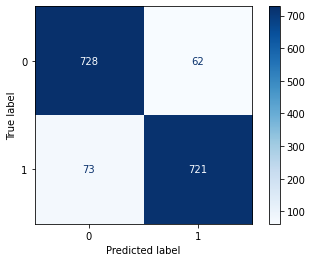

TfidfVectorizer
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       790
           1       0.92      0.93      0.92       794

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



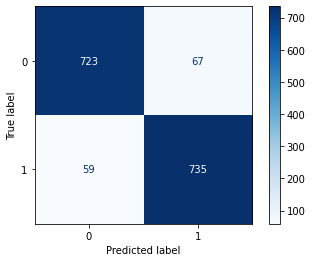

Word2Vec
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       790
           1       0.81      0.81      0.81       794

    accuracy                           0.81      1584
   macro avg       0.81      0.81      0.81      1584
weighted avg       0.81      0.81      0.81      1584



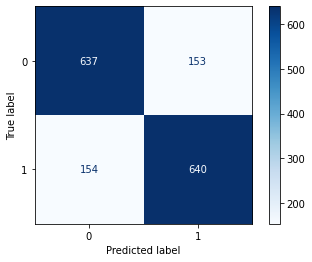

In [25]:
nb = {'CountVectorizer':[X_train_cv, X_test_cv,{'alpha': 0.1, 'fit_prior': True}],
       'TfidfVectorizer':[X_train_tfidf,X_test_tfidf,{'alpha': 0.1, 'fit_prior': False}],
       'Word2Vec':[X_train_w2v,X_test_w2v,{'alpha': 1.1, 'fit_prior': True}]
       }

param_grid_nb = [{'alpha': np.linspace(0.1, 1.5, 15),
                  'fit_prior':[True,False]}]
for vectorizer,val in nb.items():
    print(vectorizer)
       
    #gridsearchCV
    # clf_nb = MultinomialNB()
    # grid_search_nb = GridSearchCV(clf_nb,param_grid_nb,cv=3,scoring='f1_macro',n_jobs=4)
    # grid_search_nb.fit(val[0],y_train)
    # print(grid_search_nb.best_params_)
    # clf_nb = grid_search_nb.best_estimator_

    # best_estimators
    clf_nb = MultinomialNB(**val[2])
    y_pred, metric_scores = train_and_get_metric_scores(clf_nb,val[0],val[1],y_train,y_test)
    val.append(y_pred)
    val.append(metric_scores)

###       4.3. Support Vector Classifier

CountVectorizer
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       790
           1       0.92      0.92      0.92       794

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



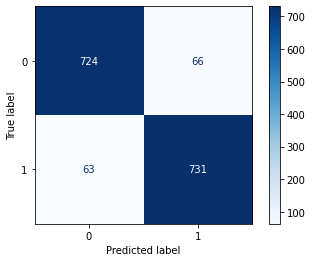

TfidfVectorizer
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       790
           1       0.96      0.96      0.96       794

    accuracy                           0.96      1584
   macro avg       0.96      0.96      0.96      1584
weighted avg       0.96      0.96      0.96      1584



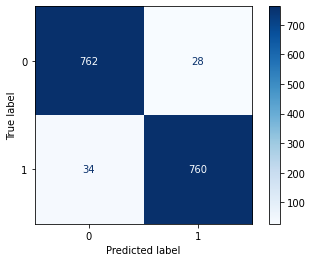

Word2Vec
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       790
           1       0.94      0.92      0.93       794

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



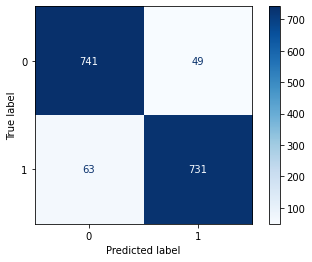

In [26]:
svm = {'CountVectorizer':[X_train_cv, X_test_cv,{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}],
       'TfidfVectorizer':[X_train_tfidf,X_test_tfidf,{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}],
       'Word2Vec':[X_train_w2v,X_test_w2v,{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}]
       }

param_grid_svm = [{
    'C': [0.1, 1, 10, 100], 
    'gamma': [1, 0.1, 0.01, 0.001, 'auto'],
    'kernel': ['rbf', 'linear','poly','sigmoid'],
                  }]

for vectorizer,val in svm.items():
    print(vectorizer)
    #gridsearchCV
    # clf_svm = SVC(random_state=42)
    # grid_search_svm = GridSearchCV(clf_svm,param_grid_svm,cv=3,scoring='f1_macro',n_jobs=4,verbose=3)
    # grid_search_svm.fit(val[0],y_train)
    # print(grid_search_svm.best_params_)
    # #clf_svm = grid_search_svm.best_estimator_

    # best_estimators
    clf_svm = SVC(random_state=42,**val[2])
    y_pred, metric_scores = train_and_get_metric_scores(clf_svm,val[0],val[1],y_train,y_test)
    val.append(y_pred)
    val.append(metric_scores)

###       4.4. Decision Tree  Classifier

CountVectorizer
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       790
           1       0.83      0.78      0.81       794

    accuracy                           0.81      1584
   macro avg       0.81      0.81      0.81      1584
weighted avg       0.81      0.81      0.81      1584



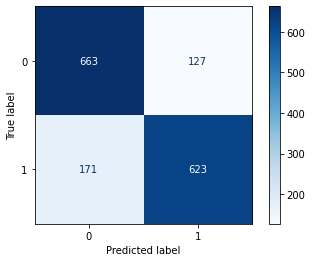

TfidfVectorizer
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       790
           1       0.80      0.85      0.82       794

    accuracy                           0.82      1584
   macro avg       0.82      0.82      0.82      1584
weighted avg       0.82      0.82      0.82      1584



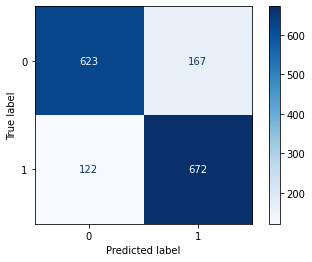

Word2Vec
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       790
           1       0.77      0.83      0.80       794

    accuracy                           0.79      1584
   macro avg       0.79      0.79      0.79      1584
weighted avg       0.79      0.79      0.79      1584



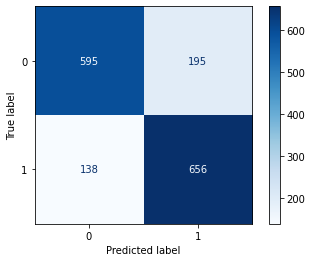

In [27]:
dt = {'CountVectorizer':[X_train_cv, X_test_cv,{'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}],
       'TfidfVectorizer':[X_train_tfidf,X_test_tfidf,{'criterion': 'gini', 'max_depth': 16, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}],
       'Word2Vec':[X_train_w2v,X_test_w2v,{'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}]
       }

param_grid_dt = [{'criterion': ['gini','entropy'],
                  'max_depth': [None,2,4,6,8,10,16,20,32,64],#[3,5,7,20,],
                  'min_samples_split':[2,3,4,5],
                  'min_samples_leaf':[1,2,3,4,5],
                  'max_features':[None,'log2','auto'], 
                 }]
for vectorizer,val in dt.items():
    print(vectorizer)
    #gridsearchCV
    # clf_dt = DecisionTreeClassifier(random_state=42)
    # grid_search_dt = GridSearchCV(clf_dt,param_grid_dt,cv=3,scoring='f1_macro',n_jobs=4,verbose=3)
    # grid_search_dt.fit(val[0],y_train)
    # print(grid_search_dt.best_params_)
    # #clf_svm = grid_search_svm.best_estimator_

    # best_estimators
    clf_dt = DecisionTreeClassifier(random_state=42,**val[2])
    y_pred, metric_scores = train_and_get_metric_scores(clf_dt,val[0],val[1],y_train,y_test)
    val.append(y_pred)
    val.append(metric_scores)

###       4.5. Random Forest Classifier

CountVectorizer
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       790
           1       0.91      0.92      0.91       794

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584



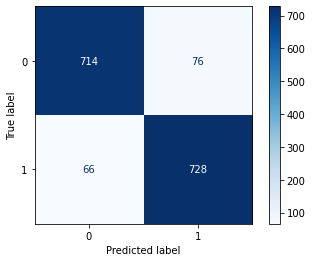

TfidfVectorizer
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       790
           1       0.92      0.92      0.92       794

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



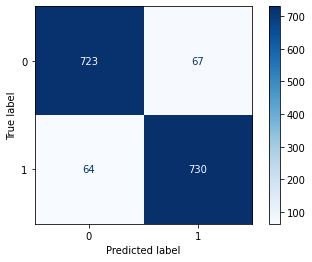

Word2Vec
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       790
           1       0.89      0.92      0.90       794

    accuracy                           0.90      1584
   macro avg       0.90      0.90      0.90      1584
weighted avg       0.90      0.90      0.90      1584



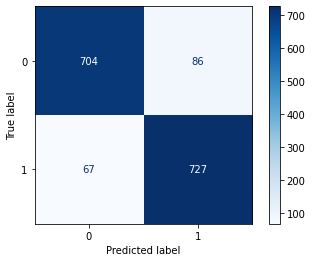

In [28]:
rf = {'CountVectorizer':[X_train_cv, X_test_cv,{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}],
       'TfidfVectorizer':[X_train_tfidf,X_test_tfidf,{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}],
       'Word2Vec':[X_train_w2v,X_test_w2v,{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}]
       }

param_grid_rf = [{'criterion':['gini','entropy'],
                  'max_depth': [None,8,16,64,128],
                  'min_samples_split': [2, 5, 10, 15],
                  'min_samples_leaf': [1, 2, 5, 10],
                  'n_estimators': [100,200, 300,400],
                  'max_features':['log2','auto'],
                 }]

for vectorizer,val in rf.items():
    print(vectorizer)
    #gridsearchCV
    # clf_rf = RandomForestClassifier(random_state=42)
    # grid_search_rf = GridSearchCV(clf_rf,param_grid_rf,cv=3,scoring='f1_macro',n_jobs=4,verbose=3)
    # grid_search_rf.fit(val[0],y_train)
    # print(grid_search_rf.best_params_)
    #clf_rf = grid_search_rf.best_estimator_

    # best_estimators
    clf_rf = RandomForestClassifier(random_state=42,**val[2])
    y_pred, metric_scores = train_and_get_metric_scores(clf_rf,val[0],val[1],y_train,y_test)
    val.append(y_pred)
    val.append(metric_scores)

###       4.6. Passive Agressive Classifier

CountVectorizer
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       790
           1       0.91      0.94      0.93       794

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



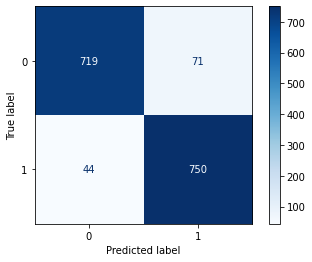

TfidfVectorizer
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       790
           1       0.97      0.96      0.96       794

    accuracy                           0.96      1584
   macro avg       0.96      0.96      0.96      1584
weighted avg       0.96      0.96      0.96      1584



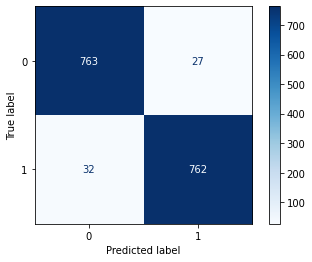

Word2Vec
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       790
           1       0.93      0.89      0.91       794

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584



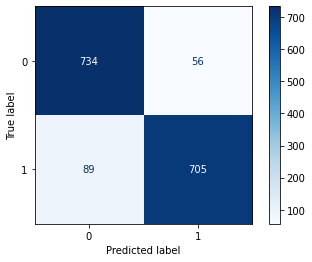

In [30]:
pa = {'CountVectorizer':[X_train_cv, X_test_cv,{'C': 0.001, 'early_stopping': True}],
       'TfidfVectorizer':[X_train_tfidf,X_test_tfidf,{'C': 0.1, 'early_stopping': False}],
       'Word2Vec':[X_train_w2v,X_test_w2v,{'C': 0.001, 'early_stopping': False}]
       }

param_grid_pa = {'C': [0.001,0.01,0.1,1,10,100,1000],
                 'early_stopping': [True,False]}

for vectorizer,val in pa.items():
    print(vectorizer)
       
    #gridsearchCV
    # clf_pa = PassiveAggressiveClassifier(random_state=42)
    # grid_search_pa = GridSearchCV(clf_pa,param_grid_pa,cv=3,scoring='f1_macro',n_jobs=4)
    # grid_search_pa.fit(val[0],y_train)
    # print(grid_search_pa.best_params_)
    # clf_pa = grid_search_pa.best_estimator_

    # best_estimators
    clf_pa = PassiveAggressiveClassifier(random_state=42,**val[2])
    y_pred, metric_scores = train_and_get_metric_scores(clf_pa,val[0],val[1],y_train,y_test)
    val.append(y_pred)
    val.append(metric_scores)

## 5. Kết quả đánh giá tổng hợp và ROC CURVES - AUC

In [93]:
model_list = {'LogisticRegression':[lr,'red'],
              'MultinomialNB':[nb,'black'],
              'SVC':[svm,'limegreen'],
              'PassiveAgressiveClassifier':[pa,'cyan'],
              'DecissionTreeClassifier':[dt,'violet'],
              'RandomForestClassifier':[rf,'orange']}

model_names = list(model_list.keys())

In [94]:
result = pd.DataFrame({'':model_names,
                       'CounVectorizer':[model_list[i][0]['CountVectorizer'][-1]['accuracy'] for i in list(model_list.keys())],
                       'TfidfVectorizer':[model_list[i][0]['TfidfVectorizer'][-1]['accuracy'] for i in list(model_list.keys())],
                       'Word2Vec':[model_list[i][0]['Word2Vec'][-1]['accuracy'] for i in list(model_list.keys())]})

result = result.set_index('')
result

,CounVectorizer,TfidfVectorizer,Word2Vec
,,,
LogisticRegression,0.9362,0.9596,0.9135
MultinomialNB,0.9148,0.9205,0.8062
SVC,0.9186,0.9609,0.9293
PassiveAgressiveClassifier,0.9274,0.9628,0.9085
DecissionTreeClassifier,0.8119,0.8176,0.7898
RandomForestClassifier,0.9104,0.9173,0.9034


**ROC Curves - AUC**

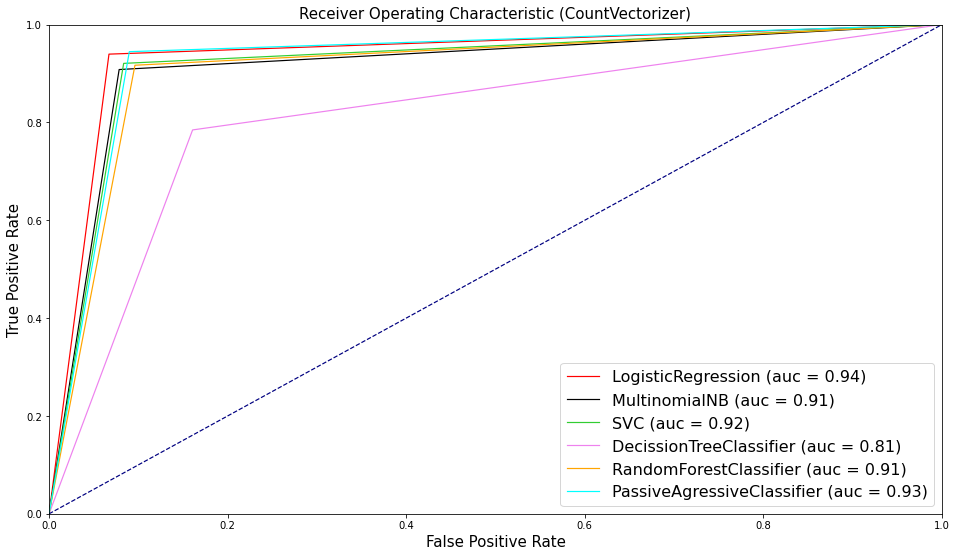

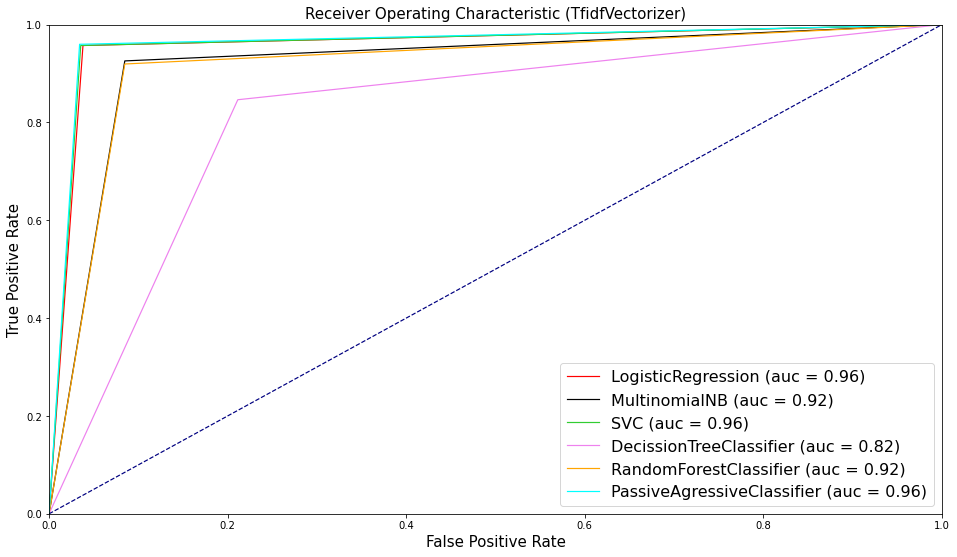

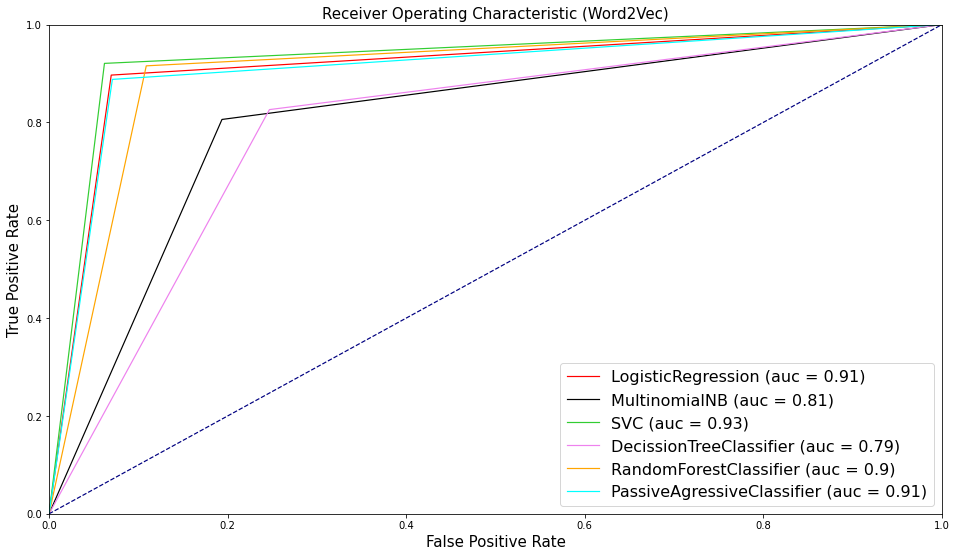

In [48]:
fpr_tpr_thres = []
vecs = ['CountVectorizer','TfidfVectorizer','Word2Vec']

for vec in vecs:
  plt.figure(figsize=(16,9))
  plt.title('Receiver Operating Characteristic ({})'.format(vec),fontsize=15)
  lw = 1.2

  for name, model in model_list.items():
    fpr, tpr, threshold = roc_curve(y_test,model[0][vec][-2])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=model[1],lw = lw, label='{} (auc = {})' .format(name,round(roc_auc,2)))

  plt.legend(loc = 'lower right',prop={'size': 16})
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate',fontsize=15)
  plt.xlabel('False Positive Rate',fontsize=15)
  plt.show()
  print("")

#Phân tích lỗi mô hình tốt nhất

In [200]:
df = pd.DataFrame({'content':X_test,
                   'label':test['label'],
                   'predict':pa['TfidfVectorizer'][-2]})
df['predict'] = df['predict'].apply(lambda x: 'FAKE' if x == 1 else 'REAL')

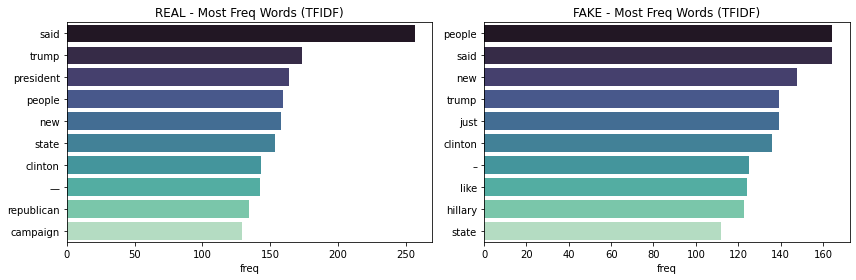

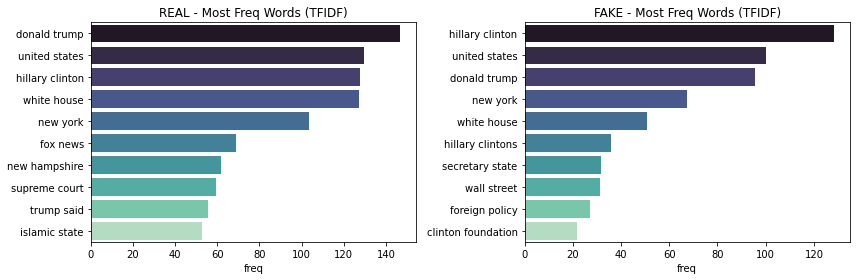

In [214]:
for i in range(2):
  labels =['REAL','FAKE']
  fig, ax = plt.subplots(1,2, figsize=(12,4))
  for indx,val in enumerate(labels):
      subset = df[df['label']==val]
      text1 = subset['content'].values
      visualize_word_freq(text1,10, val,ax[indx],(i+1,i+1),tfidf=True)
      plt.tight_layout()
  print(' ')

False Positive (REAL bị dự đoán là FAKE)

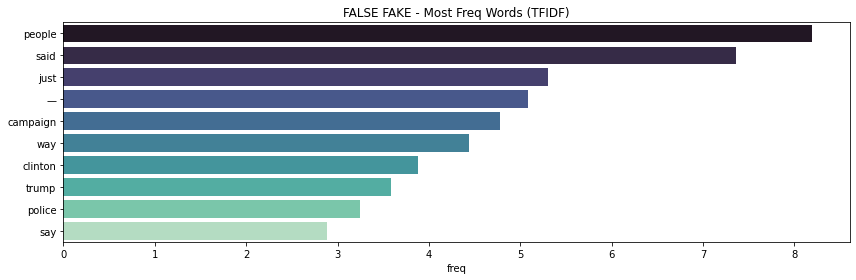

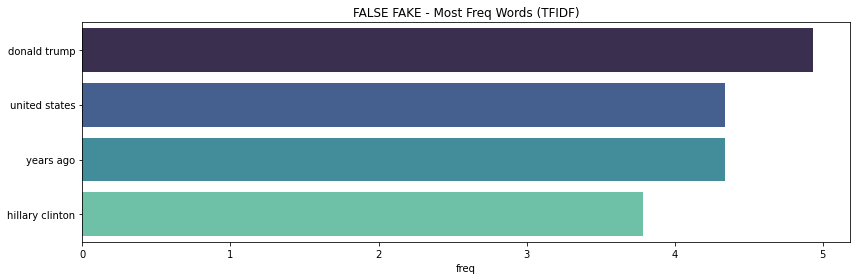

In [218]:
FP_df = df.loc[(df.label=='REAL')&(df.predict=='FAKE')]
for i in range(2):
  fig, ax = plt.subplots(1,1, figsize=(12,4))
  subset = FP_df[FP_df['predict']=='FAKE']
  text1 = subset['content'].values
  visualize_word_freq(text1,10, 'REAL but predict FAKE',ax,(i+1,i+1),tfidf=True)
  plt.tight_layout()

False Negative (FAKE bị dự đoán là REAL)

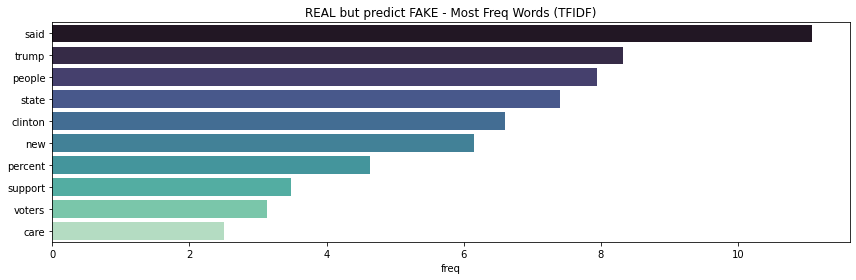

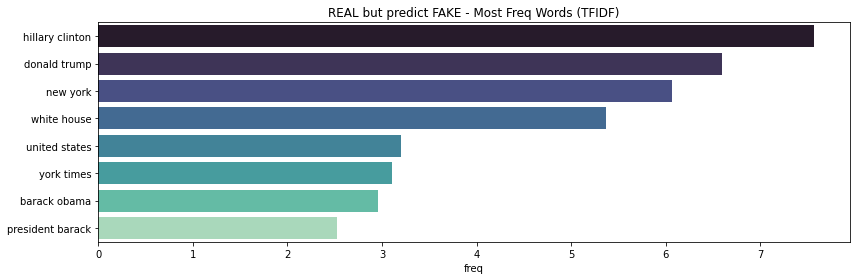

In [221]:
FN_df = df.loc[(df.label=='FAKE')&(df.predict=='REAL')]

for i in range(2):
  fig, ax = plt.subplots(1,1, figsize=(12,4))
  subset = FN_df[FN_df['predict']=='REAL']
  text1 = subset['content'].values
  visualize_word_freq(text1,10, 'REAL but predict FAKE',ax,(i+1,i+1),tfidf=True)
  plt.tight_layout()